In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

### Loading stored features

In [5]:
feature_path = "./data_route_features/route_features.csv"
route_feat_all = pd.read_csv(feature_path)

In [6]:
# Use precomputed scaled columns if present, otherwise scale on the fly
scaled_cols = [c for c in route_feat_all.columns if c.endswith("_scaled")]
if scaled_cols:
    X_hc = route_feat_all[scaled_cols].to_numpy()
    base_cols = [c[:-7] for c in scaled_cols]  # original names
else:
    num_cols = route_feat_all.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    X_hc = scaler.fit_transform(route_feat_all[num_cols])
    base_cols = num_cols

=labels = route_feat_all["route_id"].astype(str).tolist()

print("X_hc shape:", X_hc.shape)
print("Number of routes:", len(labels))
print("Feature columns used:", base_cols)

X_hc shape: (25, 14)
Number of routes: 25
Feature columns used: ['boardings_mean', 'alightings_mean', 'load_mean', 'boardings_median', 'samples', 'dir_0_count', 'dir_1_count', 'headway_mean', 'headway_std', 'scheduled_headway_mean', 'earliness_mean', 'stops_count', 'records', 'on_time_rate']


### Ward linkage dendrogram + cophenetic correlation

Cophenetic correlation (Ward): 0.558


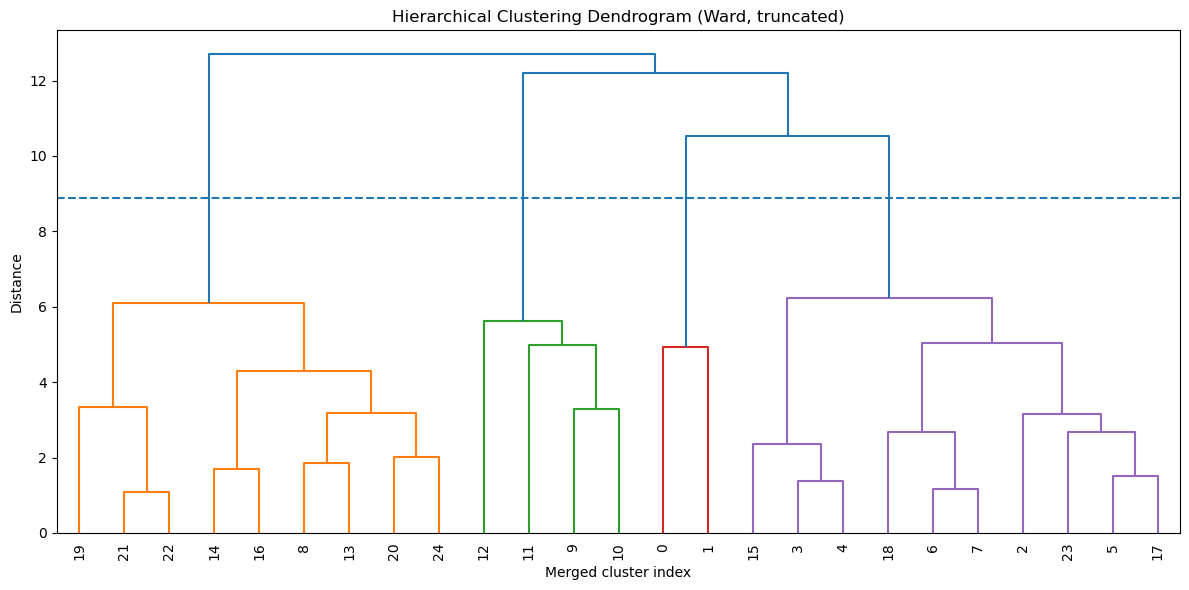

In [8]:
# pairwise distances 
D = pdist(X_hc, metric='euclidean')

# hierarchical linkage (Ward’s method minimizes within-cluster variance)
Z = linkage(D, method='ward')

# cophenetic correlation (how well the tree preserves pairwise distances)
coph_corr, _ = cophenet(Z, D)
print(f"Cophenetic correlation (Ward): {coph_corr:.3f}")

# dendrogram 
plt.figure(figsize=(12, 6))
cut_height = 0.7 * Z[:, 2].max()  # visual guide only
dendrogram(
    Z,
    truncate_mode='lastp',  # show last p merged clusters
    p=30,                   # adjust to show more/less detail
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    color_threshold=cut_height,
)
plt.title("Hierarchical Clustering Dendrogram (Ward, truncated)")
plt.xlabel("Merged cluster index")
plt.ylabel("Distance")
plt.axhline(cut_height, linestyle='--')
plt.tight_layout()
plt.show()


#### Cut dendrogram into clusters

hcluster
1     9
2     4
3     2
4    10
Name: count, dtype: int64

Cluster centroids (mean of original features):


,boardings_mean,alightings_mean,load_mean,boardings_median,samples,dir_0_count,dir_1_count,headway_mean,headway_std,scheduled_headway_mean,earliness_mean,stops_count,records,on_time_rate
hcluster,,,,,,,,,,,,,,
1,0.54,0.57,6.63,0.12,5277.67,2827.78,2449.89,774.65,435.39,695.84,-201.32,13.56,243155.11,0.13
2,0.80,0.80,11.64,0.20,103076.75,49222.75,53854.00,705.97,458.35,690.78,-150.52,27.50,483413.50,0.09
3,1.44,1.45,15.73,0.50,2124.50,947.00,1177.50,1540.67,2264.97,1527.13,-26.80,14.00,236965.50,0.01
4,1.01,1.02,12.05,0.41,9300.10,4568.50,4731.60,780.21,691.61,769.75,-129.67,22.20,508340.20,0.05


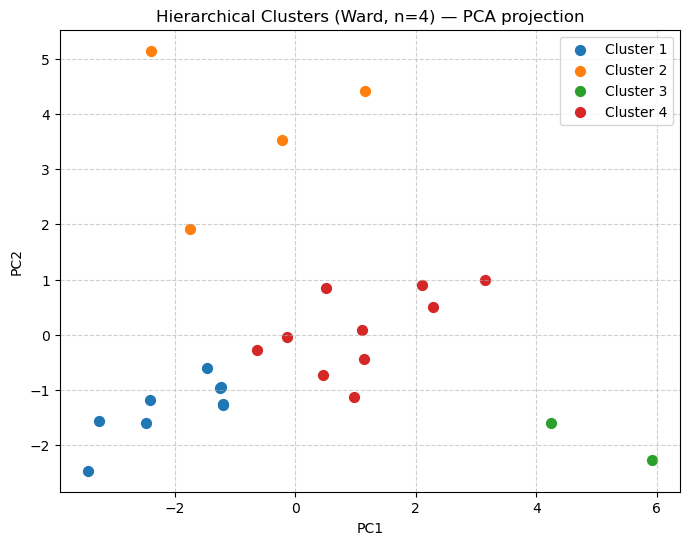

In [10]:
import pandas as pd
import numpy as np

# choose number of clusters 
n_clusters = 4  
route_feat_all['hcluster'] = fcluster(Z, n_clusters, criterion='maxclust')

# cluster sizes
print(route_feat_all['hcluster'].value_counts().sort_index())

# compute cluster means (original feature scale)
cluster_summary = (
    route_feat_all.groupby('hcluster')[base_cols]
    .mean()
    .round(2)
)

print("\nCluster centroids (mean of original features):")
display(cluster_summary)

# optional: add PCA projection to visualize clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_hc)
plot_df = pd.DataFrame(X_pca, columns=['PC1','PC2'])
plot_df['cluster'] = route_feat_all['hcluster']

plt.figure(figsize=(8,6))
for c in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=50, label=f'Cluster {c}')
plt.title(f'Hierarchical Clusters (Ward, n={n_clusters}) — PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Mapping clusters to survey demographics

### Normalize keys and explode survey to one-route-per-row

In [11]:
import re, ast

def _normalize_route(val):
    if pd.isna(val): return None
    s = str(val).strip().upper()
    if s.isdigit():
        s = s.lstrip('0') or '0'
    return s

ROUTE_TOKEN_RE = re.compile(r'(SL\d+|CT\d+|\d+[A-Z]?)', flags=re.IGNORECASE)

def _to_route_list(x):
    if isinstance(x, list):
        return [_normalize_route(t) for t in x if t is not None]
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            v = ast.literal_eval(s)
            if isinstance(v, list):
                return [_normalize_route(t) for t in v if t is not None]
        except Exception:
            pass
    # Fallback: regex tokens like SL1, 34E, 10, etc.
    toks = ROUTE_TOKEN_RE.findall(s.upper())
    return [_normalize_route(t) for t in toks]

survey_long = (
    survey_df
    .assign(route_list=lambda d: d['route_id'].apply(_to_route_list))
    .explode('route_list', ignore_index=True)
    .rename(columns={'route_list': 'route_id_str'})
    .dropna(subset=['route_id_str'])
)

# building cluster table with normalized key
route_clusters_h = (
    route_feat_all
    .assign(route_id_str=lambda d: d['route_id'].apply(_normalize_route))
    [['route_id_str','hcluster']]
)

print("survey_long routes:", survey_long['route_id_str'].nunique())
print("clustered routes:", route_clusters_h['route_id_str'].nunique())


survey_long routes: 37
clustered routes: 25


### selecting demographic slices (income and ethnicity)

In [12]:
income_mask = (
    survey_long['measure_group'].str.contains('INCOME', case=False, na=False) |
    survey_long['measure'].str.contains('INCOME', case=False, na=False) |
    survey_long['category'].str.contains('INCOME', case=False, na=False)
)

eth_mask = (
    survey_long['measure_group'].str.contains('RACE|ETHNIC', case=False, na=False) |
    survey_long['measure'].str.contains('RACE|ETHNIC', case=False, na=False) |
    survey_long['category'].str.contains('RACE|ETHNIC', case=False, na=False)
)

survey_income = survey_long.loc[income_mask, ['route_id_str','category','weighted_percent']]
survey_ethnicity = survey_long.loc[eth_mask, ['route_id_str','category','weighted_percent']]

print("Income rows:", survey_income.shape, "Ethnicity rows:", survey_ethnicity.shape)


Income rows: (356, 3) Ethnicity rows: (481, 3)


In [13]:
def _row_normalize(df):
    s = df.sum(axis=1)
    return df.div(s.replace(0, pd.NA), axis=0)

income_pivot = (
    survey_income.pivot_table(index='route_id_str', columns='category',
                              values='weighted_percent', aggfunc='mean')
    .pipe(_row_normalize)
    .reset_index()
)

ethnicity_pivot = (
    survey_ethnicity.pivot_table(index='route_id_str', columns='category',
                                 values='weighted_percent', aggfunc='mean')
    .pipe(_row_normalize)
    .reset_index()
)

print("Income categories:", list(income_pivot.columns))
print("Ethnicity categories:", list(ethnicity_pivot.columns))


Income categories: ['route_id_str', '100% to 140%  of Area Median Income', '130% to 200% of Area Median Income', '200% or more of Area Median Income', '30% to 60% of Area Median Income', '60% to 80% of Area Median Income', '80% to 100% of Area Median Income', 'Less than 40% of Area Median Income', 'No', 'Prefer not to say', 'Yes']
Ethnicity categories: ['route_id_str', 'American Indian or Alaska Native', 'Asian', 'Black or African American', 'Middle Eastern or North African', 'Native Hawaiian or other Pacific Islander', 'No', 'Other', 'Prefer not to say', 'White', 'Yes']


### Merge with hierarchical clusters and average within clusters

In [14]:
income_cluster_h = (
    income_pivot.merge(route_clusters_h, on='route_id_str', how='inner')
                .drop(columns=['route_id_str'])
                .groupby('hcluster', as_index=True).mean()
                .sort_index()
)

ethnicity_cluster_h = (
    ethnicity_pivot.merge(route_clusters_h, on='route_id_str', how='inner')
                   .drop(columns=['route_id_str'])
                   .groupby('hcluster', as_index=True).mean()
                   .sort_index()
)

print("Average income composition per hcluster (%):")
display((income_cluster_h * 100).round(1))

print("Average ethnicity composition per hcluster (%):")
display((ethnicity_cluster_h * 100).round(1))

# Quick overlap diagnostics if needed
if income_cluster_h.empty or ethnicity_cluster_h.empty:
    print("\nDEBUG — overlaps")
    print("Income overlap routes:", income_pivot['route_id_str'].isin(route_clusters_h['route_id_str']).sum())
    print("Ethnicity overlap routes:", ethnicity_pivot['route_id_str'].isin(route_clusters_h['route_id_str']).sum())


Average income composition per hcluster (%):


,100% to 140% of Area Median Income,130% to 200% of Area Median Income,200% or more of Area Median Income,30% to 60% of Area Median Income,60% to 80% of Area Median Income,80% to 100% of Area Median Income,Less than 40% of Area Median Income,No,Prefer not to say,Yes
hcluster,,,,,,,,,,
1,2.8,1.9,0.6,15.5,10.7,6.0,8.5,12.2,4.3,37.8
2,1.5,0.4,0.4,17.4,9.3,5.4,9.9,8.4,5.9,41.6
3,0.9,0.6,NaN,20.5,7.6,3.4,12.7,5.3,4.4,44.7
4,2.0,0.8,0.4,18.0,10.3,4.3,9.8,8.1,4.5,41.9


Average ethnicity composition per hcluster (%):


,American Indian or Alaska Native,Asian,Black or African American,Middle Eastern or North African,Native Hawaiian or other Pacific Islander,No,Other,Prefer not to say,White,Yes
hcluster,,,,,,,,,,
1,2.0,6.0,14.3,1.6,0.0,28.6,2.8,1.1,24.0,19.6
2,1.4,5.3,19.0,1.3,0.6,25.0,3.5,1.3,19.2,23.4
3,1.5,3.6,6.4,0.7,0.4,15.6,10.3,2.6,25.7,33.2
4,1.4,5.1,22.9,1.3,0.2,25.1,3.2,0.8,17.2,22.8


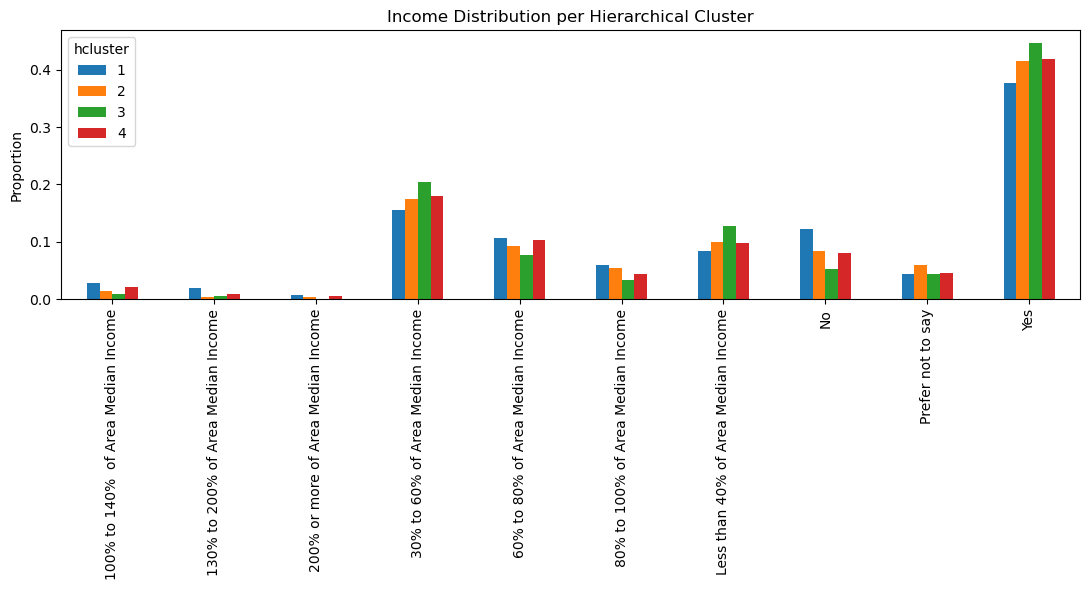

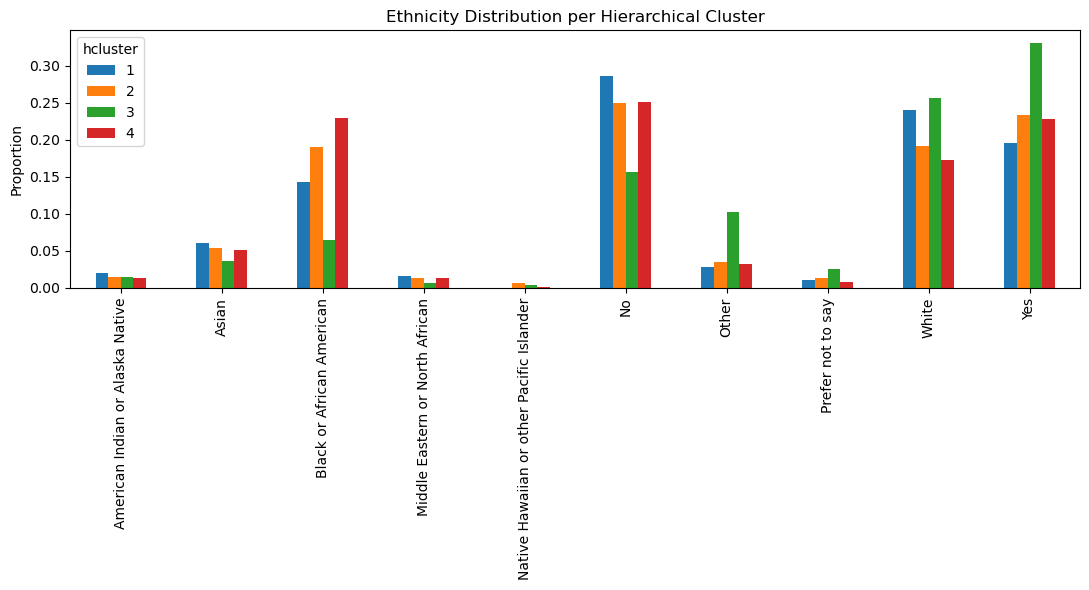

In [15]:
if not income_cluster_h.empty:
    (income_cluster_h.T).plot(kind='bar', figsize=(11,6))
    plt.title("Income Distribution per Hierarchical Cluster")
    plt.ylabel("Proportion")
    plt.legend(title='hcluster')
    plt.tight_layout()
    plt.show()

if not ethnicity_cluster_h.empty:
    (ethnicity_cluster_h.T).plot(kind='bar', figsize=(11,6))
    plt.title("Ethnicity Distribution per Hierarchical Cluster")
    plt.ylabel("Proportion")
    plt.legend(title='hcluster')
    plt.tight_layout()
    plt.show()
